Population mean: 1.7497548295354364


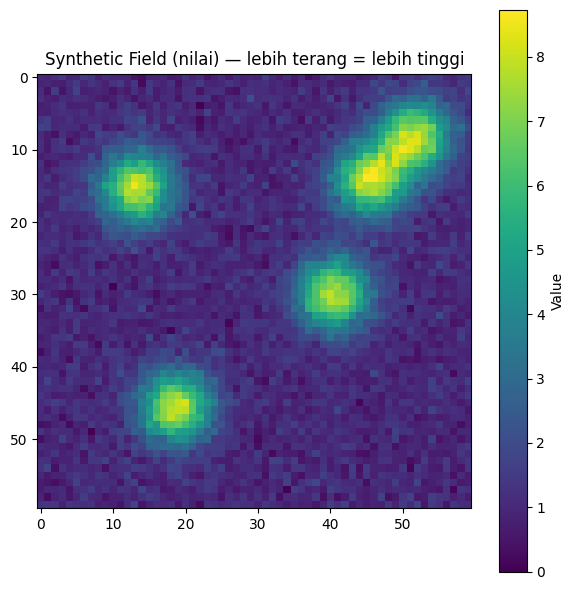

ACS threshold (quantile 0.92): 4.481

Hasil ringkas (estimasi mean populasi):
- SRS          | RMSE=0.1448 | MAE=0.1159 | Bias=0.0099 | Avg n=120.0
- Systematic   | RMSE=0.5664 | MAE=0.5234 | Bias=-0.0125 | Avg n=120.0
- ACS(HT)      | RMSE=0.0000 | MAE=0.0000 | Bias=0.0000 | Avg n=3600.0


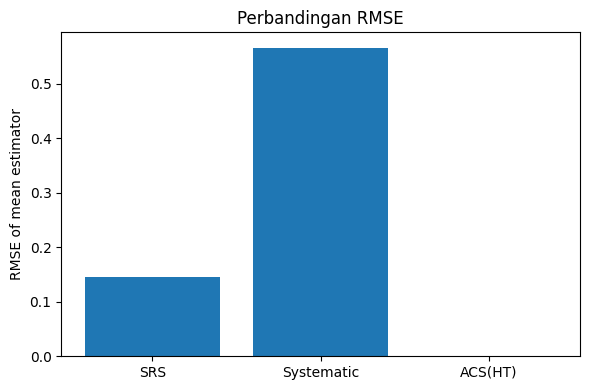

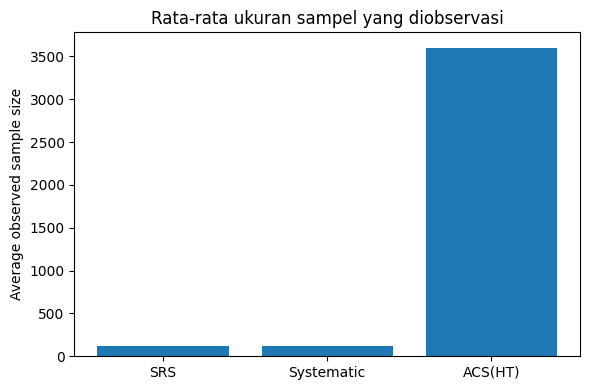

In [1]:
"""
Simulasi Adaptive Cluster Sampling (ACS) dan perbandingan
vs metode sampling biasa (Simple Random Sampling dan Systematic Sampling)

Catatan pemakaian:
- Salin setiap sel bertanda `# %%` ke Jupyter Notebook (atau jalankan langsung sebagai .py dengan IPython).
- Tidak memakai seaborn; plotting via matplotlib saja.
- Anda dapat menyesuaikan parameter di bagian CONFIG.
"""

# %% [markdown]
# # 1) Setup & Utilities
# - Membuat field 2D sintetis dengan beberapa hotspot (klaster nilai tinggi)
# - Utilitas untuk visualisasi & metrik

# %%
import numpy as np
import random
import math
import itertools
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from dataclasses import dataclass

np.random.seed(42)
random.seed(42)

# %%
@dataclass
class FieldConfig:
    H: int = 60           # tinggi grid (jumlah baris)
    W: int = 60           # lebar grid (jumlah kolom)
    n_hotspots: int = 4   # jumlah hotspot
    hotspot_sigma: float = 3.0  # lebar gaussian hotspot
    base_mean: float = 1.0      # nilai dasar latar
    base_std: float = 0.3       # noise dasar
    hotspot_amp: float = 6.0    # amplitudo puncak hotspot

# %%
class SyntheticField:
    def __init__(self, cfg: FieldConfig):
        self.cfg = cfg
        self.grid = self._make_field()
        self.H, self.W = cfg.H, cfg.W
        self.N = self.H * self.W

    def _make_field(self):
        H, W = self.cfg.H, self.cfg.W
        base = np.random.normal(self.cfg.base_mean, self.cfg.base_std, size=(H, W))
        Y, X = np.mgrid[0:H, 0:W]
        acc = np.zeros((H, W), dtype=float)
        # tempatkan hotspot gaussian acak
        for _ in range(self.cfg.n_hotspots):
            cy = np.random.uniform(0, H)
            cx = np.random.uniform(0, W)
            g = np.exp(-(((X - cx) ** 2 + (Y - cy) ** 2) / (2 * self.cfg.hotspot_sigma ** 2)))
            acc += self.cfg.hotspot_amp * g
        # gabungkan base + hotspot + noise kecil
        field = base + acc + np.random.normal(0, 0.1, size=(H, W))
        # non-negatif
        field = np.clip(field, 0, None)
        return field

    def population_mean(self):
        return float(self.grid.mean())

    def population_total(self):
        return float(self.grid.sum())

    def idx_to_rc(self, idx: int):
        return divmod(idx, self.cfg.W)

    def rc_to_idx(self, r: int, c: int):
        return r * self.cfg.W + c

# %%
# Visualisasi sederhana

def show_field(field: SyntheticField, title="Field"):
    plt.figure(figsize=(6, 6))
    plt.imshow(field.grid, origin="upper")
    plt.colorbar(label="Value")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# %% [markdown]
# # 2) Metode Sampling Biasa
# ## 2.1 Simple Random Sampling (SRS)
# - Ambil n unit secara acak tanpa memperhatikan struktur ruang
# - Estimator mean: rata-rata sampel
# - Ukuran sampel = n

# %%
@dataclass
class SRSConfig:
    n0: int  # ukuran sampel

# %%
class SRSampler:
    def __init__(self, field: SyntheticField, cfg: SRSConfig):
        self.field = field
        self.cfg = cfg

    def sample(self):
        H, W = self.field.H, self.field.W
        N = H * W
        all_idx = np.arange(N)
        chosen = np.random.choice(all_idx, size=self.cfg.n0, replace=False)
        vals = []
        for i in chosen:
            r, c = self.field.idx_to_rc(i)
            vals.append(self.field.grid[r, c])
        est_mean = float(np.mean(vals))
        return {
            "est_mean": est_mean,
            "sample_size": self.cfg.n0,
            "indices": chosen.tolist(),
        }

# %% [markdown]
# ## 2.2 Systematic Sampling (opsional baseline kedua)
# - Pilih setiap k-th unit dari start acak
# - Untuk grid, kita lakukan linearization row-major

# %%
@dataclass
class SystematicConfig:
    n0: int  # target jumlah sampel (digunakan untuk menentukan interval)

# %%
class SystematicSampler:
    def __init__(self, field: SyntheticField, cfg: SystematicConfig):
        self.field = field
        self.cfg = cfg

    def sample(self):
        N = self.field.N
        k = max(1, N // self.cfg.n0)
        start = np.random.randint(0, k)
        idxs = list(range(start, N, k))[: self.cfg.n0]
        vals = []
        for i in idxs:
            r, c = self.field.idx_to_rc(i)
            vals.append(self.field.grid[r, c])
        est_mean = float(np.mean(vals))
        return {
            "est_mean": est_mean,
            "sample_size": len(idxs),
            "indices": idxs,
        }

# %% [markdown]
# # 3) Adaptive Cluster Sampling (ACS)
# Referensi konsep: Thompson (1990). Intuisi:
# - Mulai dengan SRS awal berukuran n0.
# - Jika suatu unit memenuhi kondisi (misal nilai ≥ threshold), ekspansi ke tetangga (4-neighbors),
#   ulangi hingga tidak ada unit baru yang memenuhi kondisi.
# - Unit yang tersambung melalui jalur neighbor ke set unit yang memenuhi kondisi membentuk **network**.
# - Estimator unbiased berbasis **network Horvitz–Thompson**:
#   \( \hat{\mu} = \frac{1}{N} \sum_{k \in S_*} \frac{T_k}{\pi_k} \),
#   dengan \( T_k \) = total nilai pada network k, \( \pi_k = 1 - (1 - m_k/N)^{n0} \),
#   \( m_k \) = ukuran network (jumlah unit), dan \( S_* \) adalah himpunan **network unik** yang terambil oleh SRS awal.

# %%
@dataclass
class ACSConfig:
    n0: int            # ukuran SRS awal
    threshold: float   # kondisi adaptif: nilai >= threshold (atau aturan lain)

# %%
class ACSSampler:
    def __init__(self, field: SyntheticField, cfg: ACSConfig):
        self.field = field
        self.cfg = cfg
        self.N = self.field.N

    def neighbors4(self, r, c):
        H, W = self.field.H, self.field.W
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            rr, cc = r + dr, c + dc
            if 0 <= rr < H and 0 <= cc < W:
                yield rr, cc

    def build_networks(self):
        """
        Bangun network (komponen terkoneksi) berbasis aturan:
        - Seed: semua sel dengan value >= threshold
        - Network mencakup sel-seI yang terhubung (4-neigh) ke seed mana pun,
          termasuk sel tidak memenuhi threshold yang terjaring selama ekspansi.
        Return:
          network_id[r, c] = id network (atau -1 bila tidak terhubung ke seed)
          networks: dict id -> list indeks linear anggota
        """
        grid = self.field.grid
        H, W = self.field.H, self.field.W
        N = self.N
        qualifies = grid >= self.cfg.threshold

        visited = np.zeros((H, W), dtype=bool)
        network_id = -np.ones((H, W), dtype=int)
        networks = {}
        nid = 0

        for r in range(H):
            for c in range(W):
                if visited[r, c]:
                    continue
                # Jika sel ini tidak memenuhi threshold dan tidak tetangga ke seed apa pun,
                # kita tetap perlu cek via ekspansi hanya jika ada seed di komponen ini.
                # Strategi: lakukan BFS; tanda komponen sementara; cek apakah ada seed di dalamnya.
                comp = []
                q = deque([(r, c)])
                visited[r, c] = True
                comp_has_seed = qualifies[r, c]

                while q:
                    rr, cc = q.popleft()
                    comp.append((rr, cc))
                    for nr, nc in self.neighbors4(rr, cc):
                        if not visited[nr, nc]:
                            visited[nr, nc] = True
                            q.append((nr, nc))
                            if qualifies[nr, nc]:
                                comp_has_seed = True

                if comp_has_seed:
                    # seluruh komponen menjadi satu network
                    idxs = []
                    for (rr, cc) in comp:
                        network_id[rr, cc] = nid
                        idxs.append(self.field.rc_to_idx(rr, cc))
                    networks[nid] = idxs
                    nid += 1
                else:
                    # tetap -1 (bukan bagian network mana pun)
                    for (rr, cc) in comp:
                        network_id[rr, cc] = -1

        return network_id, networks

    def sample(self):
        N = self.N
        # Bangun network global berdasar threshold
        network_id, networks = self.build_networks()
        # SRS awal
        all_idx = np.arange(N)
        initial = np.random.choice(all_idx, size=self.cfg.n0, replace=False)
        # Kumpulkan network unik yang tersampel oleh SRS awal
        picked_networks = set()
        for i in initial:
            r, c = self.field.idx_to_rc(i)
            nid = int(network_id[r, c])
            if nid != -1:
                picked_networks.add(nid)

        # Jika tidak ada network yang terambil (semua -1), estimator jatuh ke mean dari SRS awal
        if len(picked_networks) == 0:
            vals = [self.field.grid[self.field.idx_to_rc(i)] for i in initial]
            est_mean_fallback = float(np.mean(vals))
            return {
                "est_mean": est_mean_fallback,
                "sample_size": int(self.cfg.n0),  # hanya initial SRS yang benar-benar diobservasi
                "initial_indices": initial.tolist(),
                "picked_networks": [],
                "mode": "fallback_to_srs",
            }

        # Hitung estimator HT berbasis network
        HTest = 0.0
        observed_units = set(initial.tolist())  # minimal, observe semua initial
        for nid in picked_networks:
            idxs = networks[nid]
            m_k = len(idxs)
            T_k = 0.0
            for idx in idxs:
                r, c = self.field.idx_to_rc(idx)
                val = self.field.grid[r, c]
                T_k += float(val)
                observed_units.add(idx)
            # inklusi prob jaringan k oleh SRS awal ukuran n0
            pi_k = 1.0 - (1.0 - (m_k / N)) ** self.cfg.n0
            HTest += T_k / pi_k
        est_mean = HTest / N

        return {
            "est_mean": float(est_mean),
            "sample_size": len(observed_units),
            "initial_indices": initial.tolist(),
            "picked_networks": sorted(list(picked_networks)),
            "mode": "acs_ht",
        }

# %% [markdown]
# # 4) Percobaan Monte Carlo
# - Jalankan banyak replika untuk menghitung RMSE estimator mean populasi
# - Bandingkan SRS, Systematic, dan ACS (HT)

# %%
@dataclass
class ExperimentConfig:
    runs: int = 200
    srs_n0: int = 120
    sys_n0: int = 120
    acs_n0: int = 60
    acs_threshold_quantile: float = 0.92  # threshold diambil dari kuantil field (misal 92%)

# %%
@dataclass
class MethodResult:
    name: str
    rmse: float
    mean_abs_err: float
    bias: float
    avg_sample_size: float

# %%
def run_experiment(field: SyntheticField, ecfg: ExperimentConfig):
    pop_mean = field.population_mean()

    # tentukan threshold ACS dari kuantil value grid
    q = np.quantile(field.grid, ecfg.acs_threshold_quantile)
    acs_cfg = ACSConfig(n0=ecfg.acs_n0, threshold=float(q))
    srs_cfg = SRSConfig(n0=ecfg.srs_n0)
    sys_cfg = SystematicConfig(n0=ecfg.sys_n0)

    acs = ACSSampler(field, acs_cfg)
    srs = SRSampler(field, srs_cfg)
    sys = SystematicSampler(field, sys_cfg)

    stats = {
        "SRS": {"err2": [], "abs": [], "bias": [], "ss": []},
        "Systematic": {"err2": [], "abs": [], "bias": [], "ss": []},
        "ACS(HT)": {"err2": [], "abs": [], "bias": [], "ss": []},
    }

    for _ in range(ecfg.runs):
        r1 = srs.sample()
        e1 = r1["est_mean"] - pop_mean
        stats["SRS"]["err2"].append(e1 * e1)
        stats["SRS"]["abs"].append(abs(e1))
        stats["SRS"]["bias"].append(e1)
        stats["SRS"]["ss"].append(r1["sample_size"])

        r2 = sys.sample()
        e2 = r2["est_mean"] - pop_mean
        stats["Systematic"]["err2"].append(e2 * e2)
        stats["Systematic"]["abs"].append(abs(e2))
        stats["Systematic"]["bias"].append(e2)
        stats["Systematic"]["ss"].append(r2["sample_size"])

        r3 = acs.sample()
        e3 = r3["est_mean"] - pop_mean
        stats["ACS(HT)"]["err2"].append(e3 * e3)
        stats["ACS(HT)"]["abs"].append(abs(e3))
        stats["ACS(HT)"]["bias"].append(e3)
        stats["ACS(HT)"]["ss"].append(r3["sample_size"])

    results = []
    for name, d in stats.items():
        rmse = float(np.sqrt(np.mean(d["err2"])) if d["err2"] else float("nan"))
        mae = float(np.mean(d["abs"]) if d["abs"] else float("nan"))
        bias = float(np.mean(d["bias"]) if d["bias"] else float("nan"))
        ss = float(np.mean(d["ss"]) if d["ss"] else float("nan"))
        results.append(MethodResult(name, rmse, mae, bias, ss))
    return results, q

# %% [markdown]
# # 5) Demo Cepat
# - Buat field sintetis
# - Tampilkan peta
# - Jalankan eksperimen & plot ringkas

# %%
# ===== CONFIG =====
fcfg = FieldConfig(H=60, W=60, n_hotspots=5, hotspot_sigma=3.5, hotspot_amp=7.0)
ecfg = ExperimentConfig(runs=200, srs_n0=120, sys_n0=120, acs_n0=60, acs_threshold_quantile=0.92)

# build field & show
field = SyntheticField(fcfg)
print("Population mean:", field.population_mean())

show_field(field, title="Synthetic Field (nilai) — lebih terang = lebih tinggi")

# %%
# Jalankan eksperimen Monte Carlo
results, thr = run_experiment(field, ecfg)

# ringkas hasil
print(f"ACS threshold (quantile {ecfg.acs_threshold_quantile:.2f}): {thr:.3f}")
print("\nHasil ringkas (estimasi mean populasi):")
for r in results:
    print(f"- {r.name:12s} | RMSE={r.rmse:.4f} | MAE={r.mean_abs_err:.4f} | Bias={r.bias:.4f} | Avg n={r.avg_sample_size:.1f}")

# %%
# Visual komparasi RMSE dan rata-rata ukuran sampel
names = [r.name for r in results]
rmse = [r.rmse for r in results]
avg_n = [r.avg_sample_size for r in results]

plt.figure(figsize=(6,4))
plt.bar(names, rmse)
plt.ylabel("RMSE of mean estimator")
plt.title("Perbandingan RMSE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.bar(names, avg_n)
plt.ylabel("Average observed sample size")
plt.title("Rata-rata ukuran sampel yang diobservasi")
plt.tight_layout()
plt.show()

# %% [markdown]
# # 6) Catatan & Tips Penyesuaian
# - **Pemilihan threshold ACS** penting: gunakan kuantil (mis. 90–95%) atau ambang domain (mis. DO < 4 mg/L).
# - **Ukuran SRS awal n0**: makin kecil n0, ACS akan lebih mengandalkan ekspansi; makin besar n0, peluang menyentuh network naik.
# - Estimator ACS yang dipakai adalah **Horvitz–Thompson pada level network** dengan peluang inklusi \(\pi_k = 1 - (1 - m_k/N)^{n0}\).
# - Jika dalam satu run tidak ada network yang tersampel, kode fallback ke mean SRS awal.
# - Anda dapat mengganti tetangga 4-neigh menjadi 8-neigh bila fenomena spasial lebih menyebar.
# - Untuk benchmark lain, tambahkan **Stratified** atau **Cluster sampling** konvensional bila ada strata geografis.

# %% [markdown]
# ---
# ## API ringkas untuk integrasi ke program Anda
# 
# - Bangun `SyntheticField` dari data Anda (atau modifikasi agar membaca raster/numpy Anda).
# - Gunakan `ACSSampler(field, ACSConfig(n0, threshold)).sample()` untuk 1 kali run.
# - Jalankan `run_experiment(field, ExperimentConfig(...))` untuk evaluasi RMSE/MAE/bias dan effort.
# 
# Silakan sesuaikan parameter di blok CONFIG sesuai karakter data bawah air (DO, pH, suhu, salinitas).
